## Lab 9: Predicting Forest Cover Type with SVMs

### Introduction
In this lab, we will explore the application of Support Vector Machines (SVMs) and Random Forests (RFs) for multi-class classification using cartographic variables. Specifically, we will predict forest cover type based on a variety of environmental features such as elevation, soil type, and land aspect.

Understanding forest cover classification is crucial for natural resource management. Land managers and conservationists rely on accurate predictions of vegetation types to make informed decisions about wildlife habitats, fire management, and sustainable forestry practices. However, direct field assessments of forest cover can be costly and time-consuming, making predictive models a valuable tool for estimating cover types in large or inaccessible regions.

Dataset info here: https://archive.ics.uci.edu/dataset/31/covertype


### Step 0: Load Libraries and Data

In [1]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/courses/EDS232/Data/covtype_sample.csv")

### Step 1: Data Preprocessing 

Before building our classification models, we need to prepare the dataset by separating the features target variable (`Cover_Type`) and  splitting the data into training and test sets. 

We didn't explicitly discuss it in lecture, but SVMs are sensitive to feature scale.  Use `describe()` to summarize the dataset.  Do you see anything that would require scaling of the data?  If so, apply that transformation.

In [2]:
# Look at the data
pd.set_option('display.max_columns', None)
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Rawah,Wilderness_Area_Neota,Wilderness_Area_Comanche,Wilderness_Area_Poudre,Soil_Type,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,3136,228,7,810,-7,6329,210,247,174,1307,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
1,2898,129,12,201,4,853,240,233,121,2550,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2
2,2765,74,16,268,134,2850,237,208,98,6452,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,3078,189,10,582,-39,2554,221,247,160,1463,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,3141,159,11,466,-33,1080,231,242,141,1120,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2


In [3]:
# Select features and target
X = df.drop('Cover_Type', axis = 1)
y = df['Cover_Type']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 808)

In [4]:
# Check to see if features require scaling
X.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Rawah,Wilderness_Area_Neota,Wilderness_Area_Comanche,Wilderness_Area_Poudre,Soil_Type,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2955.599500,154.450000,14.114700,268.097600,45.755300,2319.360300,212.19660,223.113500,142.243800,1960.040200,0.447600,0.047000,0.438300,0.067100,0.006000,0.010500,0.00840,0.019800,0.003200,0.013100,0.000200,0.000300,0.00190,0.057000,0.023200,0.049100,0.028800,0.001500,0.0,0.005300,0.006600,0.003200,0.007900,0.016100,0.00160,0.053300,0.096700,0.035200,0.001000,0.003600,0.002200,0.001300,0.197900,0.054400,0.046000,0.091200,0.082900,0.00250,0.00250,0.000200,0.000500,0.026800,0.024500,0.013600
std,281.786673,111.851861,7.499705,211.899673,58.034207,1548.558651,26.98846,19.871067,37.799752,1320.535941,0.497272,0.211649,0.496203,0.250208,0.077231,0.101935,0.09127,0.139319,0.056481,0.113709,0.014141,0.017319,0.04355,0.231854,0.150546,0.216088,0.167252,0.038703,0.0,0.072612,0.080976,0.056481,0.088535,0.125866,0.03997,0.224642,0.295564,0.184294,0.031609,0.059895,0.046855,0.036034,0.398436,0.226817,0.209496,0.287908,0.275745,0.04994,0.04994,0.014141,0.022356,0.161507,0.154603,0.115829
min,1860.000000,0.000000,0.000000,0.000000,-164.000000,0.000000,68.00000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2804.750000,58.000000,9.000000,95.000000,7.000000,1091.750000,198.00000,213.000000,119.000000,1006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2995.000000,126.000000,13.000000,218.000000,29.000000,1977.000000,218.00000,226.000000,142.000000,1699.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3159.000000,258.000000,18.000000,384.000

All of the soil_type variables are magnitudes smaller than our other variables. I would say that this dataset does require scaling.

In [5]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the training set
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test set
X_test_scaled = scaler.transform(X_test)

### Step 2: Hyperparameter Tuning for SVM
To optimize our SVM model, we need to search for the best hyperparameters that maximize classification accuracy. Since SVM performance depends heavily on `C`, `kernel`, and `gamma`, we will use `GridSearchCV()` to systematically test different combinations. Initialize a cross validation object with 5 folds using `StratifiedKFold`. Check out how `StratifiedKFold` differs from `Kfold` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). 

Then, set up a grid to test different values of: 
- `C` (regularization strength): how strictly the model fits the training data
  - Candidate parameter values: `(0.1, 1, 10, 100)`
- `kernel` (decision boundary shape): compares linear and radial basis function shapes
  - Candidate parameter values: (linear, rbf)
- `gamma` (influence of training observations): influence of individual points on decision boundary
  - Candidate parameter values: (scale, auto)

As models and datasets become more complex, consideration of computation time becomes more important.  You'll use `time.time()` to measure the time required to fit the grid object.  

**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [6]:
# Initalize SVM classifier
svm = SVC()

# Initalize StratifiedKFold CV object
skf = StratifiedKFold(n_splits = 5)

In [7]:
# Set up parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Set up GridSearch
gs_svm = GridSearchCV(svm, param_grid, cv = skf, n_jobs = -1, verbose = 0)

In [8]:
# Record the start time
start_time_svm = time.time()

# Fit grid search
gs_svm.fit(X_train_scaled, y_train)

# Record the end time
end_time_svm = time.time()

In [9]:
# Calculate time elapsed
elapsed_time_svm = end_time_svm - start_time_svm
print(f"Time taken for SVM: {elapsed_time_svm:.2f} seconds")

# Print the best parameters
print(f"Best SVM Parameters: {gs_svm.best_params_}")

Time taken for SVM: 1242.91 seconds
Best SVM Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


### Step 3: Build a fit a Random Forest for comparison

Let's compare our SVM to a Random Forest classifier.  Create a grid for cross-validation with three hyperparameters of your choice to tune, along with three sensible values for each one.  
**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [10]:
# Construct parameter grid
param_grid_rf = {
    "max_features":["sqrt", 6, None],
    "n_estimators":[50, 100, 200],
    "max_depth":[3,5,7]
}


# Initialize Random forest classifier
rf = RandomForestClassifier(random_state = 808)

# Initialize grid search cv
gs_rf = GridSearchCV(rf, param_grid_rf, cv = skf, n_jobs = -1, verbose = 0)

In [11]:
# Record the start time
start_time_rf = time.time()

# Fit grid search
gs_rf.fit(X_train_scaled, y_train)

# Record the end time
end_time_rf = time.time()

In [12]:
# Calculate time elapsed
elapsed_time_rf = end_time_rf - start_time_rf
print(f"Time taken for GridSearchCV: {elapsed_time_rf:.2f} seconds")

# Print the best parameters
print(f"Best Parameters: {gs_rf.best_params_}")

Time taken for GridSearchCV: 13.99 seconds
Best Parameters: {'max_depth': 7, 'max_features': None, 'n_estimators': 50}


### Step 4: Model Predictions and Evaluation
Now that you have trained and optimized both a SVM and RF model, you will evaluate their performances on the test set to prepare for model comparison. In this step, you will:
- Use the best models from `GridSearchCV()` to make predictions on the test set
- Generate a confusion matrix for each model to visualize classification performance


In [13]:
# Initalize best SVM model
svm_best = SVC(**gs_svm.best_params_, random_state = 808)

# Train SVM model
svm_best.fit(X_train_scaled, y_train)

# Generate SVM test predictions
svm_best_pred = svm_best.predict(X_test_scaled)



# Initalize best RF model
rf_best = RandomForestClassifier(**gs_rf.best_params_, random_state = 808)

# Train RF model
rf_best.fit(X_train_scaled, y_train)

# Generate RF test predictions
rf_best_pred = rf_best.predict(X_test_scaled)

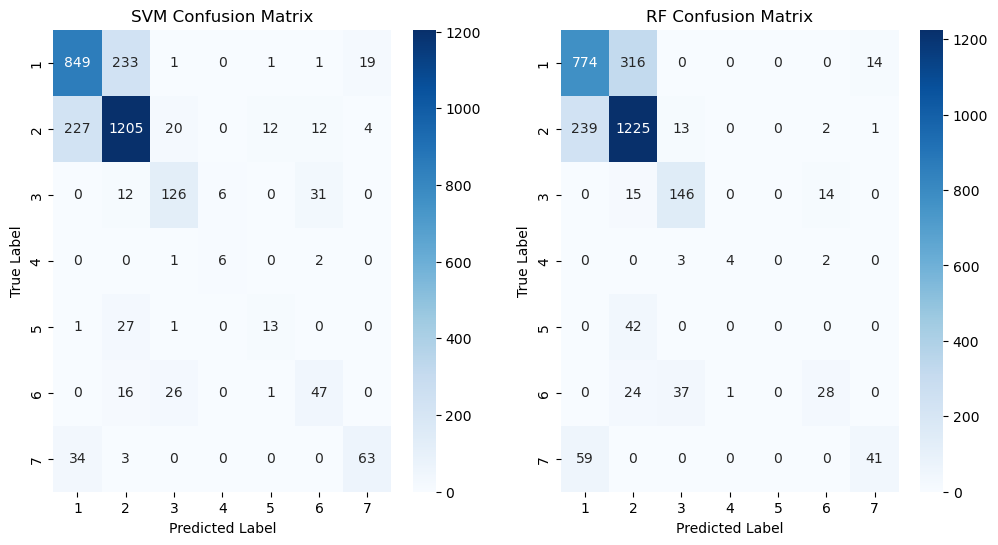

In [17]:
# Create confusion matrices
svm_cm = confusion_matrix(y_test, svm_best_pred)
rf_cm = confusion_matrix(y_test, rf_best_pred)

# Plot SVM confusion matrix
plt.figure(figsize = (12,6))
plt.subplot(1, 2, 1)
sns.heatmap(svm_cm, fmt = 'd', cmap = 'Blues', xticklabels = range(1,8),
               yticklabels = range(1,8), annot = True)
plt.title('SVM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot RF confusion matrix
plt.subplot(1, 2, 2)
#plt.figure(figsize = (8,6))
sns.heatmap(rf_cm, fmt = 'd', cmap = 'Blues', xticklabels = range(1,8),
               yticklabels = range(1,8), annot = True)
plt.title('RF Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

### Step 5: Gather and display additional performance metrics
Now display the accuracy score and training time required for each model to so we can compare the models.

In [15]:
# Performance metrics
print(f"SVM accuracy: {accuracy_score(y_test, svm_best_pred):.3f} and training time: {elapsed_time_svm:.2f} seconds")
print(f"RF accuracy: {accuracy_score(y_test, rf_best_pred):.3f} and training time: {elapsed_time_rf:.2f} seconds")

SVM accuracy: 0.770 and training time: 1242.91 seconds
RF accuracy: 0.739 and training time: 13.99 seconds


### Step 6: Compare the models
Now that we have trained, optimized, and evaluated both SVM and RF models, we will compare them based on overall accuracy, training time, and types of errors made.

Based on these comparisons, which model is more suitable for this task?  


The accuracies of the two models are pretty similar, SVM is slightly higher. However, the SVM model has significantly higher computation time, at about 20 minutes compared to the RF's 14 seconds. From looking at the confusion matrix, I'd say that the SVM model predicted true positives more consistently across forest cover types than the random forest model. There are some forest cover types that the RF model never predicted correctly. Without calculating, it seems like the FP and FN rates are similar between the two models. 

Based on these comparisons, we are taking on a significant amount of computation time for a slight increase in performance. Making a generalization about which model is more suitable for the task depends on the consequences of error in our application. If we were using this model to make any policy decisions, I would say that the extra time required for training the SVM is worth the increased performance, especially considering that the RF model fails to capture some forest types entirely. However, for a simple application with little consequence, I would say that the RF model is fine.